In [1]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization to /tmp/pip-req-build-0df3t3ae
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization /tmp/pip-req-build-0df3t3ae
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 298 kB 38.9 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=144999 sha256=4674a80d978dbaa1e874b2cabb05df61f15b8ff1f1c998e1ba435226a21a3ee9
  Stored in directory: /tmp/pip-ephem-wheel-cache-u6wy_cjy/wheels/eb/7f/26/4a3835d3d83e17ac1d9bed33d09ecdd6dd423759b38e69c270
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=67b323163349c59ea7c8c7611f195626b71e7a955ff1b4c202aa2d1eae19bbf6
  Stored in directory

In [2]:
!pip3 install cma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 249 kB 30.5 MB/s 


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cma

from bayes_optim import BO
from bayes_optim.search_space import RealSpace
from bayes_optim.surrogate import GaussianProcess, trend

from benchmark.bbobbenchmarks import F10, F11, F12, F13, F14, F15, F16, F21

In [4]:
dim = 2
lb, ub = -5, 5

space = RealSpace([lb, ub]) * dim

mean = trend.constant_trend(dim, beta=None)
thetaL = 1e-10 * (ub - lb) * np.ones(dim)
thetaU = 10 * (ub - lb) * np.ones(dim)
theta0 = np.random.rand(dim) * (thetaU - thetaL) + thetaL

doe_sizes = (5, 10, 15, 20)
max_FEs = 50
verbose = False

n_samples = 1000

max_cma_iter = 10

PLOT_SIZE = (20, 10)

In [5]:
opt_color, found_color, initial_color = "green", "red", "blue"


def plot(points, colors, ax=plt, outline=False, marker='o'):
    transposed = np.transpose(points)
    if outline:
        ax.scatter(transposed[0], transposed[1], color="none", edgecolor=colors, marker=marker)
    else:
        ax.scatter(transposed[0], transposed[1], c=colors, marker=marker)
  
def plot_result(func, samples, values, result, ax):
  plot(samples, values, ax=ax, outline=False)
  if result["initial_points"] is not None:
    plot(result["initial_points"], ["blue"] * result["initial_points"].shape[0], ax=ax, marker='^')
  ax.set_title(f'{result.get("description", "regret")}: {result["regret"]}', size=6)
  plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=ax, marker='s')

In [6]:
def make_optimizer(obj_func, doe, random_seed=1):
    model = GaussianProcess(
        mean=mean,
        corr="squared_exponential",
        theta0=theta0,
        thetaL=thetaL,
        thetaU=thetaU,
        nugget=0,
        noise_estim=False,
        optimizer="BFGS",
        wait_iter=3,
        random_start=dim,
        likelihood="concentrated",
        eval_budget=100 * dim,
    )
    return BO(
        search_space=space,
        obj_fun=obj_func,
        model=model,
        DoE_size=len(doe),
        acquisition_fun="EI",
        initial_points=doe,
        max_FEs=max_FEs,
        verbose=verbose,
        n_point=1, 
        random_seed=random_seed
    )
    
def regret_function(obj_func, doe_size):
    def func(X):
        doe = np.split(X, doe_size)
        opt = make_optimizer(obj_func, doe)
        _, value, _ = opt.run()
        return value - obj_func.getfopt()
    return func

## Experiments

In [7]:
sigma0 = ub / 3 # the optimum is expected to lie within x0 +- 3 * sigma0

def cma_es_experiment(obj_function, doe_size, bo_seed=1, cma_seed=1111):
  regret_func = regret_function(obj_function, doe_size)
  doe_flattened, es = cma.fmin2(regret_func, np.zeros(doe_size * dim), sigma0, {'maxiter': max_cma_iter, 'seed': cma_seed})
  doe = np.split(doe_flattened, doe_size)
  opt = make_optimizer(obj_function, np.split(es.best.x, doe_size), bo_seed)
  x, value, _ = opt.run()
  samples = space.sample(n_samples)
  values = obj_function(samples)
  regret = value - obj_function.getfopt()
  print(f'Regret is: {regret}, Found x: {x}, Found f: {value}, Optimal f: {obj_function.getfopt()}, Optimum x: {obj_function._xopt}')
  plot_result(obj_func, samples, values, {"initial_points": np.array(doe), "regret": regret, "found_x": x}, plt.gca())
  return doe

In [8]:
def plot_test_result(func, samples, values, result, ax):
  plot(samples, values, ax=ax, outline=False)
  plot(result["initial_points"], ["blue"] * len(result["initial_points"]), ax=ax, marker='^')
  plot(result["removed_point"], ["blue"], ax=ax, marker='x')
  ax.set_title(f'{result.get("description", "regret")}: {result["regret"]}', size=6)
  plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=ax, marker='s')

def plot_test(func, samples, values, results):
    fig, axs = plt.subplots(1, len(results))
    fig.suptitle("Objective function " + func.__class__.__name__, fontsize=8)
    for (result, ax) in zip(results, axs):
        plot_test_result(func, samples, values, result, ax)
    plt.show()

In [9]:
def test_doe(obj_func, doe):
  result = []
  for i in range(len(doe)):
    removed_point = doe[i]
    reduced_doe = doe[:i] + doe[i + 1:]
    opt = make_optimizer(obj_func, reduced_doe)
    x, value, _ = opt.run()
    samples = space.sample(n_samples)
    values = obj_func(samples)
    regret = value - obj_func.getfopt()
    print(f'Regret is: {regret} without {removed_point}')
    result.append({"removed_point": removed_point, "regret": regret, "found_x": x, "found_f": value, "initial_points": reduced_doe})
  samples = space.sample(n_samples)
  values = obj_func(samples)
  plot_test(obj_func, samples, values, result)
  return result, samples, values

#F21


In [11]:
obj_func = F21(1)

## DoE of size 3

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1111, Wed Oct 19 05:57:55 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 3.073741363913101e-01 1.0e+00 1.59e+00  2e+00  2e+00 1:10.7
    2     18 2.963351018547655e-02 1.2e+00 1.65e+00  2e+00  2e+00 2:28.9
    3     27 4.619457316898945e-03 1.4e+00 1.76e+00  2e+00  2e+00 3:43.0
    4     36 2.630430606771483e-04 1.5e+00 1.69e+00  2e+00  2e+00 4:52.5
    5     45 4.066289290701519e-02 1.6e+00 1.61e+00  1e+00  2e+00 6:01.0
    6     54 1.228147426388659e-04 1.6e+00 1.59e+00  1e+00  2e+00 7:23.0
    7     63 1.047167505014102e-03 1.8e+00 1.43e+00  1e+00  2e+00 8:31.5
    8     72 1.548052239783715e-04 1.8e+00 1.37e+00  1e+00  2e+00 9:41.2
    9     81 1.153098163705124e-03 2.1e+00 1.33e+00  1e+00  1e+00 10:51.1
   10     90 3.770153327309345e-07 2.1e+00 1.36e+00  1e+00  2e+00 12:03.1
termination on maxiter=10 (Wed Oct 19 06:10:10 2022)
final/bestever f-value = 4.946838e-01 3.770153e-07
incu

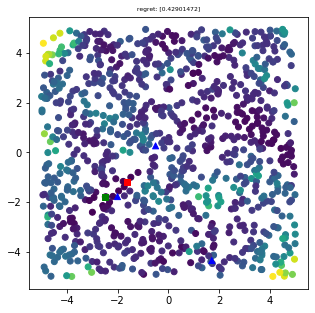

In [23]:
doe_size = 3

plt.rcParams["figure.figsize"] = (5, 5)
doe3 = cma_es_experiment(obj_func, doe_size)

Regret is: [0.00356294] without [ 1.71142173 -4.34234261]
Regret is: [0.42278231] without [-0.50388799  0.26674062]
Regret is: [0.00023171] without [-2.00442749 -1.77252565]


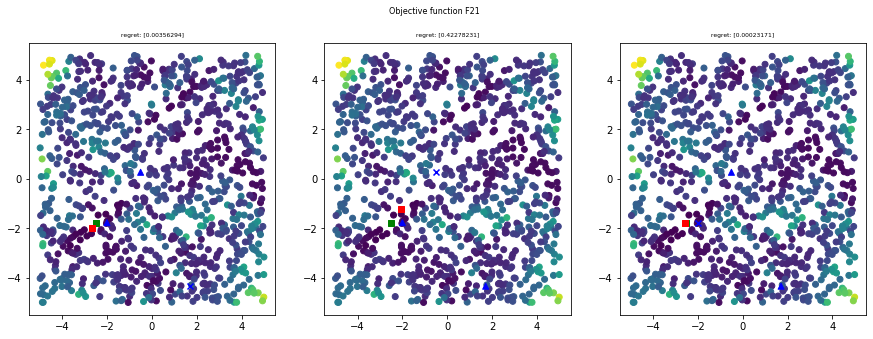

In [40]:
plt.rcParams["figure.figsize"] = (15, 5)
result3 = test_doe(obj_func, doe3) # remove each point from the doe and compute error

## DoE of size 5

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1111, Wed Oct 19 20:21:41 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 6.547526335083376e-04 1.0e+00 1.59e+00  2e+00  2e+00 1:17.3
    2     20 1.201259692848566e-03 1.2e+00 1.52e+00  1e+00  2e+00 2:33.7
    3     30 9.251094242091540e-02 1.2e+00 1.40e+00  1e+00  1e+00 3:44.7
    4     40 1.976510011019172e-04 1.3e+00 1.33e+00  1e+00  1e+00 4:57.1
    5     50 3.330119340338911e-02 1.3e+00 1.24e+00  1e+00  1e+00 6:14.2
    6     60 5.117859291630111e-04 1.4e+00 1.10e+00  1e+00  1e+00 7:30.2
    7     70 2.817444626401766e-05 1.4e+00 1.11e+00  1e+00  1e+00 8:47.4
    8     80 2.580318472162446e-03 1.4e+00 1.11e+00  1e+00  1e+00 10:05.3
    9     90 8.912496049333640e-04 1.5e+00 1.10e+00  1e+00  1e+00 11:19.5
   10    100 2.433789840452505e-04 1.5e+00 1.07e+00  1e+00  1e+00 12:33.8
termination on maxiter=10 (Wed Oct 19 20:34:23 2022)
final/bestever f-value = 3.421483e-03 2.817445e-05
i

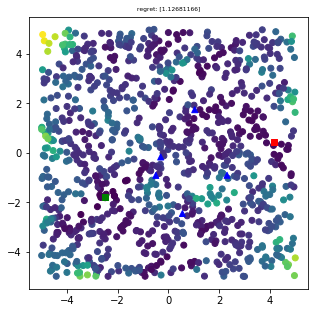

In [57]:
doe_size = 5

plt.rcParams["figure.figsize"] = (5, 5)
doe5 = cma_es_experiment(obj_func, doe_size)

Regret is: [8.49496991e-06] without [-0.86092344 -0.92576086]
Regret is: [0.06883743] without [ 1.46690891 -0.95206345]
Regret is: [0.00020413] without [ 2.61882894 -0.87307642]
Regret is: [0.12518197] without [-2.2618488  -0.71858661]
Regret is: [0.06481087] without [-1.02078024 -2.30453277]


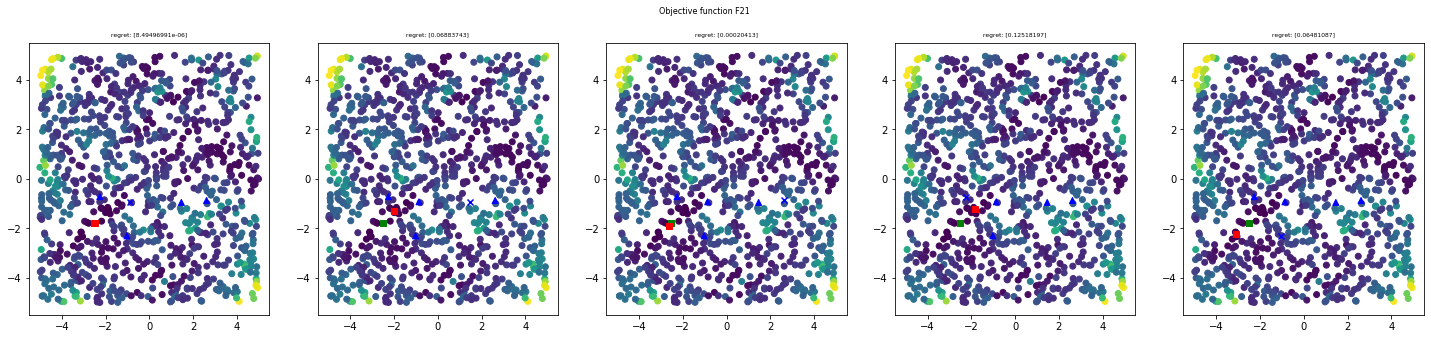

In [42]:
plt.rcParams["figure.figsize"] = (25, 5)
result5 = test_doe(obj_func, doe5)

## DoE of size 10

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 20 (seed=1111, Wed Oct 19 19:12:28 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.721452383883104e-03 1.0e+00 1.57e+00  2e+00  2e+00 1:25.1
    2     24 6.678707848095655e-06 1.1e+00 1.48e+00  1e+00  1e+00 2:42.7
    3     36 6.520623328185593e-04 1.1e+00 1.43e+00  1e+00  1e+00 4:08.8
    4     48 1.739535312005103e-03 1.1e+00 1.45e+00  1e+00  1e+00 5:28.7
    5     60 3.579679647685907e-03 1.2e+00 1.47e+00  1e+00  2e+00 6:53.4
    6     72 6.228947463426948e-05 1.2e+00 1.53e+00  1e+00  2e+00 8:22.2
    7     84 2.274914233879599e-05 1.3e+00 1.55e+00  1e+00  2e+00 9:46.6
    8     96 6.057498227107772e-05 1.3e+00 1.52e+00  1e+00  2e+00 11:14.8
    9    108 2.318286644324985e-04 1.3e+00 1.56e+00  1e+00  2e+00 12:39.7
   10    120 4.087282123506952e-03 1.4e+00 1.60e+00  2e+00  2e+00 14:11.1
termination on maxiter=10 (Wed Oct 19 19:26:45 2022)
final/bestever f-value = 1.890892e+00 6.678708e-06
i

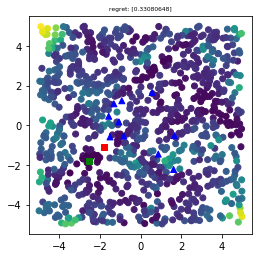

In [37]:
doe_size = 10

plt.rcParams["figure.figsize"] = (4, 4)
doe10 = cma_es_experiment(obj_func, doe_size)

Regret is: [0.00295859] without [ 1.61899065 -0.33825718]
Regret is: [1.32004332e-06] without [1.30133787 3.705842  ]
Regret is: [0.00043918] without [-1.91188334 -1.06072791]
Regret is: [0.00121338] without [-0.0419692  -0.45575589]
Regret is: [0.00155272] without [ 0.19426533 -1.14959901]
Regret is: [0.15148839] without [0.38818777 1.84844488]
Regret is: [0.4098218] without [ 0.01679018 -0.37489701]
Regret is: [0.08535375] without [-1.95993377 -1.15504484]
Regret is: [0.07588431] without [-0.47945006 -0.05463508]
Regret is: [0.00710731] without [-1.34110728  2.51688772]


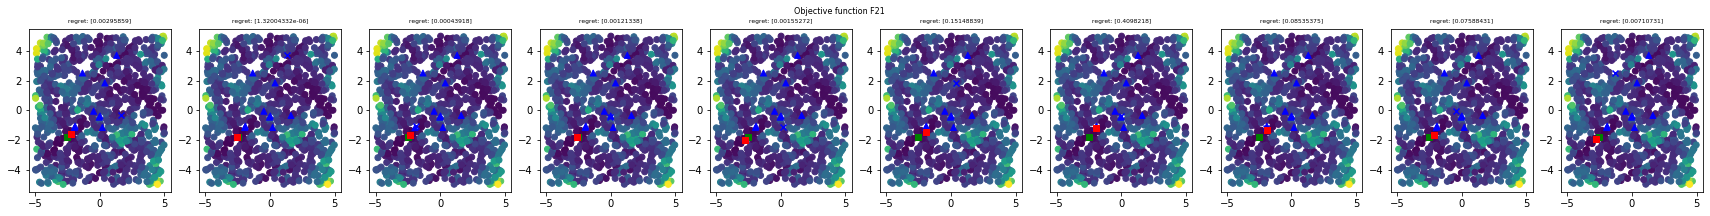

In [46]:
plt.rcParams["figure.figsize"] = (30, 3)
result10 = test_doe(obj_func, doe10)

## DoE of size 20

(7_w,15)-aCMA-ES (mu_w=4.5,w_1=34%) in dimension 40 (seed=1111, Wed Oct 19 17:27:55 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 1.700575779892688e-04 1.0e+00 1.57e+00  2e+00  2e+00 1:17.2
    2     30 3.523610030242708e-05 1.1e+00 1.50e+00  1e+00  2e+00 2:43.3
    3     45 2.219181227118838e-04 1.1e+00 1.46e+00  1e+00  1e+00 4:04.4
    4     60 2.863581904932744e-05 1.1e+00 1.45e+00  1e+00  1e+00 5:26.6
    5     75 1.433883767276711e-08 1.1e+00 1.43e+00  1e+00  1e+00 6:58.5
    6     90 2.358732949900855e-04 1.1e+00 1.41e+00  1e+00  1e+00 8:30.4
    7    105 2.202880921373662e-04 1.1e+00 1.41e+00  1e+00  1e+00 10:01.8
    8    120 2.139168358894494e-06 1.1e+00 1.40e+00  1e+00  1e+00 11:31.8
    9    135 2.874511680062142e-05 1.2e+00 1.39e+00  1e+00  1e+00 13:00.8
   10    150 3.840823963230378e-05 1.2e+00 1.38e+00  1e+00  1e+00 14:34.6
termination on maxiter=10 (Wed Oct 19 17:42:36 2022)
final/bestever f-value = 6.285248e-10 6.285248e-10


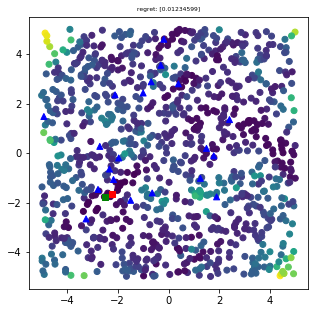

In [12]:
doe_size = 20

plt.rcParams["figure.figsize"] = (5, 5)
doe20 = cma_es_experiment(obj_func, doe_size)

Regret is: [0.13907838] without [ 1.25536923 -1.01936577]
Regret is: [0.00109165] without [-2.32513422 -0.64480862]
Regret is: [0.00426682] without [-2.1076452   2.35326858]
Regret is: [0.00241044] without [ 1.89373715 -1.76852954]
Regret is: [0.06962123] without [-1.96335489 -0.19637288]
Regret is: [0.00629026] without [-2.7078911   0.27116614]
Regret is: [0.00358999] without [-3.24898854 -2.66150534]
Regret is: [0.00398649] without [0.38799113 2.79894699]
Regret is: [0.01136041] without [-0.30309105  3.54828142]
Regret is: [0.00335263] without [-2.16877465 -1.06707049]
Regret is: [0.0193482] without [-1.00090272  2.42827327]
Regret is: [0.03014275] without [-0.18375393  4.59990103]
Regret is: [0.00367807] without [-4.91107743  1.47800355]
Regret is: [0.08138475] without [-2.77817767 -1.46751366]
Regret is: [0.43112492] without [-0.64352787 -1.61217455]
Regret is: [0.00015779] without [2.4019873 1.3536854]
Regret is: [0.0537504] without [-0.68510858  2.88020359]
Regret is: [0.00242099

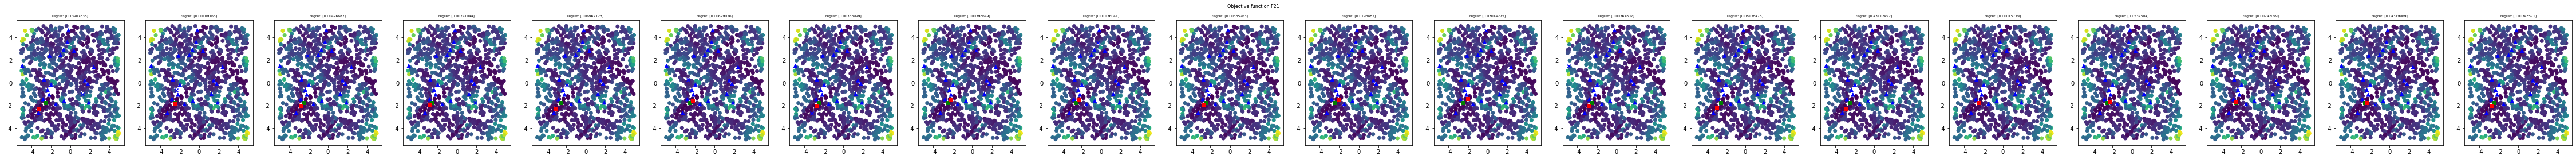

In [15]:
plt.rcParams["figure.figsize"] = (80, 4)
result20 = test_doe(obj_func, doe20)

## DoE of size 25

(7_w,15)-aCMA-ES (mu_w=4.5,w_1=34%) in dimension 50 (seed=1111, Wed Oct 19 17:55:53 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 3.846291847509065e-05 1.0e+00 1.57e+00  2e+00  2e+00 1:22.7
    2     30 2.943756881492732e-04 1.0e+00 1.51e+00  1e+00  2e+00 2:40.1
    3     45 1.744768728144663e-04 1.0e+00 1.46e+00  1e+00  1e+00 3:58.0
    4     60 4.132372038156973e-05 1.1e+00 1.42e+00  1e+00  1e+00 5:11.4
    5     75 3.082124229628391e-03 1.1e+00 1.39e+00  1e+00  1e+00 6:28.5
    6     90 6.116243390863474e-06 1.1e+00 1.37e+00  1e+00  1e+00 7:44.3
    7    105 3.516054933783153e-05 1.1e+00 1.35e+00  1e+00  1e+00 9:01.1
    8    120 1.798361820490868e-03 1.1e+00 1.33e+00  1e+00  1e+00 10:16.9
    9    135 4.032489527361349e-05 1.1e+00 1.32e+00  1e+00  1e+00 11:37.3
   10    150 4.098465917223848e-05 1.1e+00 1.31e+00  1e+00  1e+00 12:58.8
termination on maxiter=10 (Wed Oct 19 18:08:57 2022)
final/bestever f-value = 1.435375e+00 6.116243e-06
i

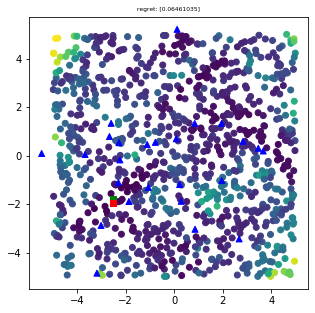

In [16]:
doe_size = 25

plt.rcParams["figure.figsize"] = (5, 5)
doe25 = cma_es_experiment(obj_func, doe_size)

Regret is: [0.01734328] without [0.84846441 1.32464639]
Regret is: [4.82130793e-05] without [-2.2338119  -0.18074219]
Regret is: [0.03136691] without [-3.18022927 -4.8513191 ]
Regret is: [0.57166979] without [1.95444974 1.32031073]
Regret is: [1.24351681] without [-2.665393    0.78311114]
Regret is: [0.01366489] without [0.08761642 0.69153468]
Regret is: [0.00412302] without [ 2.68044319 -3.43990581]
Regret is: [1.13652212] without [-2.5948194   1.32908798]
Regret is: [0.04901735] without [-5.45930883  0.08448417]
Regret is: [1.60714074] without [3.46886095 0.30043669]
Regret is: [6.42097553e-06] without [ 0.22633455 -1.19513576]
Regret is: [0.0054737] without [2.8413693  0.58557228]
Regret is: [0.50533186] without [-1.06361529 -1.31283615]
Regret is: [0.01425874] without [-0.77192201  0.54431466]
Regret is: [0.00125731] without [-3.00879692 -2.88331483]
Regret is: [0.0900591] without [-1.86098909 -1.89465844]
Regret is: [0.00178044] without [ 1.96441396 -1.03569969]
Regret is: [1.0463

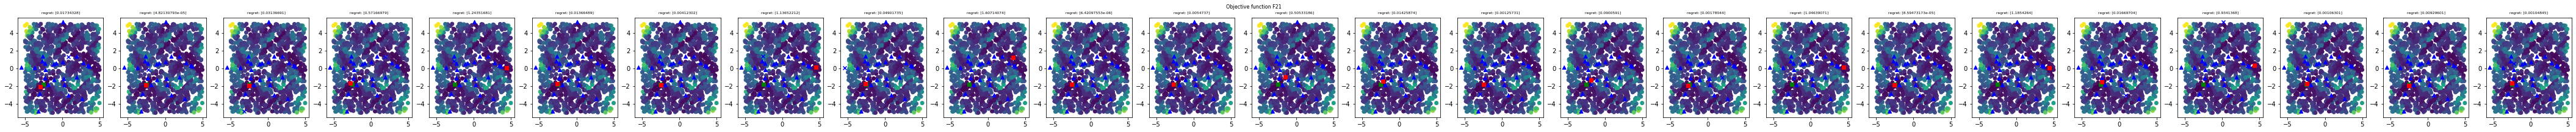

In [17]:
plt.rcParams["figure.figsize"] = (75, 3)
result25 = test_doe(obj_func, doe25)

#-F21


In [50]:
samples = space.sample(10000)
values = obj_func(samples)
neg_opt_idx = values.argmax()
neg_xopt, neg_fopt = samples[neg_opt_idx], - values[neg_opt_idx]

class NegatedF21(F21):
  def __call__(self, x):
    return - super().__call__(x)
  
  def getfopt(self):
    return neg_fopt

neg_obj_func = NegatedF21(1)
neg_obj_func._xopt = neg_xopt

## DoE of size 5

Regret is: [35.97838653] without [ 2.3021894  -0.90626111]
Regret is: [-0.5960012] without [ 0.54699877 -2.45436881]
Regret is: [2.0438709] without [-0.30646695 -0.16698393]
Regret is: [8.38546475] without [1.03290112 1.74600546]
Regret is: [6.68467888] without [-0.49702749 -0.91142738]


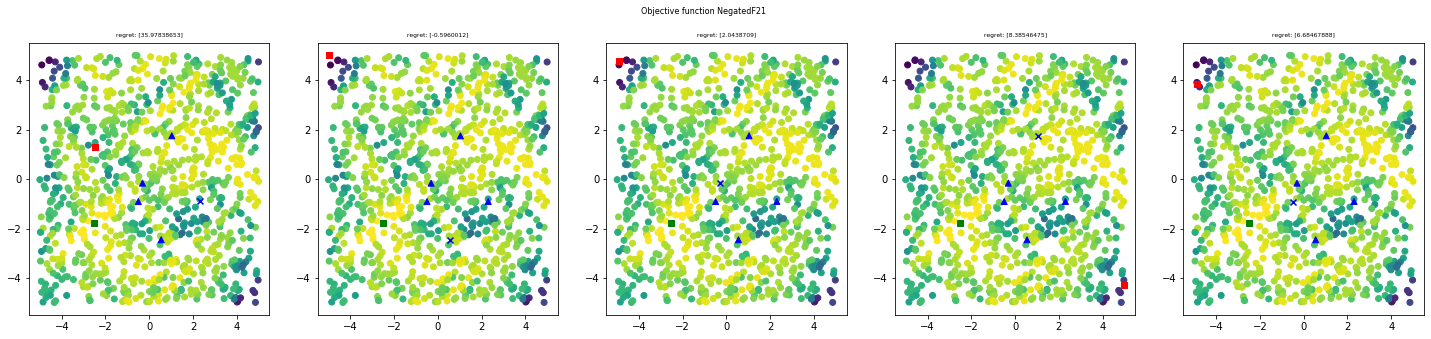

In [58]:
plt.rcParams["figure.figsize"] = (25, 5)
neg_result5 = test_doe(neg_obj_func, doe5)

## DoE of size 10

Regret is: [13.41045182] without [ 0.87269537 -1.45777772]
Regret is: [-0.5960012] without [ 1.6692667  -0.52456914]
Regret is: [5.11750085] without [-1.50208807 -0.58822445]
Regret is: [10.09759178] without [-1.06527306  0.16661621]
Regret is: [13.23496462] without [-0.9218535   1.23760748]
Regret is: [6.09122649] without [-1.56550549  0.45469677]
Regret is: [15.36764858] without [0.57106685 1.65198696]
Regret is: [11.57137471] without [-1.31148566  1.08398681]
Regret is: [3.85943248] without [-0.8204942 -0.5466439]
Regret is: [19.41130137] without [ 1.62790918 -2.23213249]


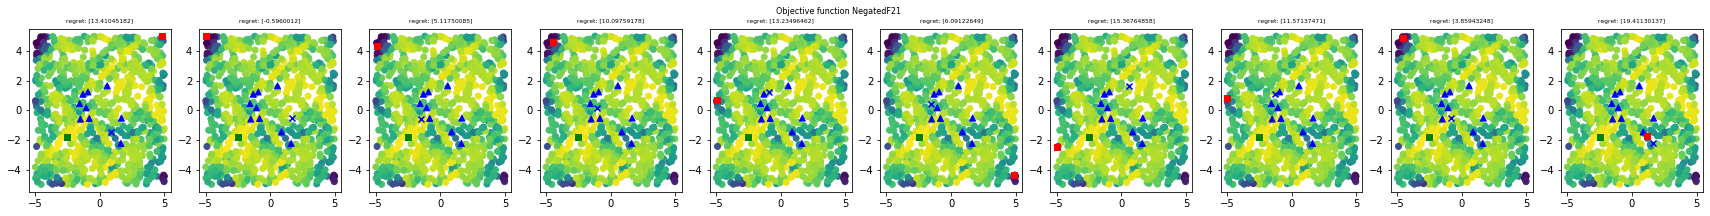

In [51]:
doe_size = 10

plt.rcParams["figure.figsize"] = (30, 3)
result_neg_10 = test_doe(neg_obj_func, doe10)

## DoE of size 20

Regret is: [18.39769497] without [ 1.25536923 -1.01936577]
Regret is: [8.88428038] without [-2.32513422 -0.64480862]
Regret is: [12.04239733] without [-2.1076452   2.35326858]
Regret is: [12.05701015] without [ 1.89373715 -1.76852954]
Regret is: [12.83566257] without [-1.96335489 -0.19637288]
Regret is: [24.17997415] without [-2.7078911   0.27116614]
Regret is: [-0.31191058] without [-3.24898854 -2.66150534]
Regret is: [2.58935083] without [0.38799113 2.79894699]
Regret is: [21.77759784] without [-0.30309105  3.54828142]
Regret is: [23.35078407] without [-2.16877465 -1.06707049]
Regret is: [19.62428071] without [-1.00090272  2.42827327]
Regret is: [7.07630387] without [-0.18375393  4.59990103]
Regret is: [13.23611112] without [-4.91107743  1.47800355]
Regret is: [7.58666817] without [-2.77817767 -1.46751366]
Regret is: [29.47537971] without [-0.64352787 -1.61217455]
Regret is: [22.75765735] without [2.4019873 1.3536854]
Regret is: [24.95166677] without [-0.68510858  2.88020359]
Regret 

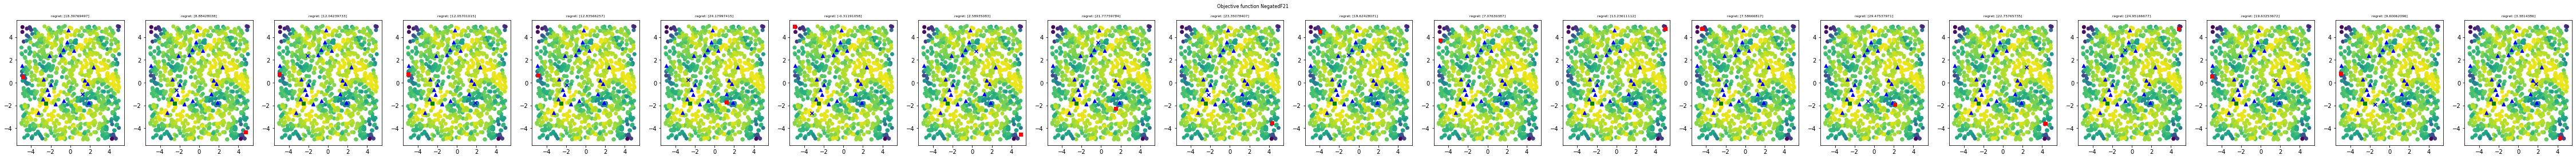

In [53]:
doe_size = 20
plt.rcParams["figure.figsize"] = (80, 4)
neg_result20 = test_doe(neg_obj_func, doe20)

## DoE of size 25

Regret is: [12.28474936] without [0.84846441 1.32464639]
Regret is: [3.32128508] without [-2.2338119  -0.18074219]
Regret is: [33.23603368] without [-3.18022927 -4.8513191 ]
Regret is: [12.32163606] without [1.95444974 1.32031073]
Regret is: [5.07582813] without [-2.665393    0.78311114]
Regret is: [7.72934426] without [0.08761642 0.69153468]
Regret is: [-0.5960012] without [ 2.68044319 -3.43990581]
Regret is: [17.45746308] without [-2.5948194   1.32908798]
Regret is: [6.62680862] without [-5.45930883  0.08448417]
Regret is: [15.80066346] without [3.46886095 0.30043669]
Regret is: [10.02133457] without [ 0.22633455 -1.19513576]
Regret is: [7.17248943] without [2.8413693  0.58557228]
Regret is: [17.38846669] without [-1.06361529 -1.31283615]
Regret is: [1.97910824] without [-0.77192201  0.54431466]
Regret is: [-0.5960012] without [-3.00879692 -2.88331483]
Regret is: [9.72993898] without [-1.86098909 -1.89465844]
Regret is: [1.68871869] without [ 1.96441396 -1.03569969]
Regret is: [15.67

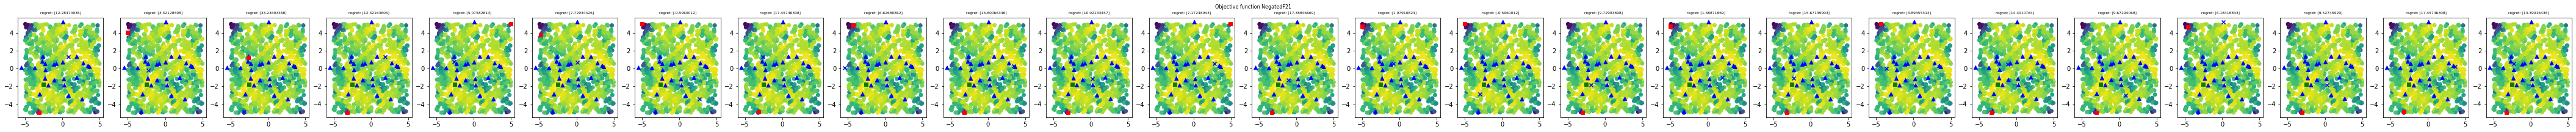

In [60]:
plt.rcParams["figure.figsize"] = (75, 3)
neg_result25 = test_doe(neg_obj_func, doe25)